Forked from  [Object Detection with YOLO blog series](https://fairyonice.github.io/tag/object-detection-using-yolov2-on-pascal-voc2012-series.html)

Notebooks were only modified as needed, vast majority of the contents are from fairyonice.github repository.

My changes covering all notebooks were:
- Use Kaggle Wheat Detection data
- Migrate to TF 2.x
- Modified Data Generator and Loss to remove tensor error
- New notebook using albumentations for image & box augmentation
- New Kaggle submission notebook



In [ ]:
# Comment out if not using Google Colab

#"""
# Google Collab specific stuff....
from google.colab import drive
#, force_remount=True
drive.mount('/content/drive') 

import os
!ls "/content/drive/My Drive"

USING_COLLAB = True
%tensorflow_version 2.x
#"""

In [ ]:
# Comment out if not using Google Colab

# Upload your "kaggle.json" file that you created from your Kaggle Account tab
# If you downloaded it, it would be in your "Downloads" directory
from google.colab import files
files.upload()

In [4]:
# Comment out if not using Google Colab

# Double check to see what files already exist
!ls

drive  kaggle.json  sample_data


In [5]:
# Comment out if not using Google Colab

# On your VM, create kaggle directory and modify access rights
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [6]:
# Comment out if not using Google Colab

# Install kaggle libs
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.5MB 5.0MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 2.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=3674c57e5637ba5fa3d6c6eee4c300d3dcc00f85fbacaa376341acde034b4aa1
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
Kaggle API 1.5.6


In [7]:
# Comment out if not using Google Colab

# Download salt files and unzip
!kaggle competitions download -c global-wheat-detection
!ls
!unzip -q global-wheat-detection.zip


 98% 593M/607M [00:04<00:00, 102MB/s]
100% 607M/607M [00:04<00:00, 131MB/s]
drive  global-wheat-detection.zip  kaggle.json	sample_data


In [8]:
# Comment out if not using Google Colab

!ls 

drive			    kaggle.json  sample_submission.csv	train
global-wheat-detection.zip  sample_data  test			train.csv


In [9]:
# Comment out if not using Google Colab

!wget https://pjreddie.com/media/files/yolov2.weights
!ls

--2020-09-04 19:13:00--  https://pjreddie.com/media/files/yolov2.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘yolov2.weights’

yolov2.weights      100%[===================>] 194.49M   499KB/s    in 6m 14s  

2020-09-04 19:19:15 (532 KB/s) - ‘yolov2.weights’ saved [203934260/203934260]

drive			    sample_data		   train
global-wheat-detection.zip  sample_submission.csv  train.csv
kaggle.json		    test		   yolov2.weights


In [10]:
# if needed, install albumentations

#!pip3 install albumentations

In [11]:
# Setup sys.path to find MachineLearning lib directory

try: USING_COLLAB
except NameError: USING_COLLAB = False

import sys
if "MachineLearning" in sys.path[0]:
    pass
else:
    print(sys.path)
    if USING_COLLAB:
        sys.path.insert(0, '/content/drive/My Drive/GitHub/MachineLearning/lib') ###### CHANGE FOR SPECIFIC ENVIRONMENT
        print(sys.path)    


['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']
['/content/drive/My Drive/GitHub/MachineLearning/lib', '', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


In [12]:
"""
import os
import sys
USING_COLLAB = True
%tensorflow_version 2.x

sys.path.insert(0, '/content/drive/My Drive/GitHub/MachineLearning/lib') ###### CHANGE FOR SPECIFIC ENVIRONMENT
"""

In [13]:
%load_ext autoreload
%autoreload 2


In [14]:
# imports and display software versions

import matplotlib.pyplot as plt
import numpy as np
import os, sys
import tensorflow as tf
print(sys.version)
%matplotlib inline

from sklearn.model_selection import train_test_split

import pandas as pd
print("Pandas: ", pd.__version__)

3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
Pandas:  1.0.5


In [15]:
# if needed....

import gc # Garbage Collector

import resource # resource usage
def memory_usage(point=""):
    usage=resource.getrusage(resource.RUSAGE_SELF)
    return '''%s: usertime=%s systime=%s mem=%s mb
           '''%(point,usage[0],usage[1],
                usage[2]/1024.0 )

print(memory_usage("Memory at start: "))


Memory at start: : usertime=5.34661 systime=1.262025 mem=349.18359375 mb
           


In [16]:
# SETUP FILE LOCATIONS BASED ON ENVIRONMENT

# For Google Collab
MODEL_PATH = "/content/drive/My Drive/ImageData/KaggleWheat/"  ###### CHANGE FOR SPECIFIC ENVIRONMENT
ROOT_PATH="./"

# Home
#ROOT_PATH = "/Users/john/Documents/Python-Working/Kaggle-global-wheat-detection/"  ###### CHANGE FOR SPECIFIC ENVIRONMENT
#MODEL_PATH = "/Users/john/Documents/Python-Working/2-Kaggle-Wheat/"  ###### CHANGE FOR SPECIFIC ENVIRONMENT

# Kaggle
#ROOT_PATH = "../input/global-wheat-detection/"  ###### CHANGE FOR SPECIFIC ENVIRONMENT
#MODEL_PATH = "../input/wheatmodel/"  ###### CHANGE FOR SPECIFIC ENVIRONMENT

##################################################################
TRAIN_DATA_PATH = os.path.join(ROOT_PATH, "train/")
TEST_DATA_PATH = os.path.join(ROOT_PATH, "test/")
MODEL_NAME = "model-wheat-yolo-1024-A2-aug2.h5"
YOLO_WEIGHT_PATH = "./yolov2.weights"

## Define anchor box
<code>ANCHORS</code> defines the number of anchor boxes and the shape of each anchor box.
The choice of the anchor box specialization is already discussed in [Part 1 Object Detection using YOLOv2 on Pascal VOC2012 - anchor box clustering](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html). 

Based on the K-means analysis in the previous blog post, I will select 4 anchor boxes of following width and height. The width and heights are rescaled in the grid cell scale (Assuming that the number of grid size is 13 by 13.) See [Part 2 Object Detection using YOLOv2 on Pascal VOC2012 - input and output encoding](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html) to learn how I rescal the anchor box shapes into the grid cell scale.

Here I choose 4 anchor boxes. With 13 by 13 grids, every frame gets 4 x 13 x 13 = 676 bouding box predictions.

In [17]:

ANCHORS = np.array([0.06960639, 0.06130531,
                    0.11246752, 0.10739992])


## Define Label vector containing 1 object classe names.

In [18]:
LABELS = ['wheat']


## Read images and annotations into memory
Use the pre-processing code for parsing annotation at [experiencor/keras-yolo2](https://github.com/experiencor/keras-yolo2).
This <code>parse_annoation</code> function is already used in [Part 1 Object Detection using YOLOv2 on Pascal VOC2012 - anchor box clustering](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html) and saved in my python script. 
This script can be downloaded at [my Github repository, FairyOnIce/ObjectDetectionYolo/backend](https://github.com/FairyOnIce/ObjectDetectionYolo/blob/master/backend.py).

In [19]:
# Load csvTRAIN_DATA_PATH
train_full_df = pd.read_csv(os.path.join(ROOT_PATH, 'train.csv'))
train_full_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [20]:
from backend import parse_annotation

np.random.seed(10)

train_full_list, seen_train_labels = parse_annotation(train_full_df, LABELS, TRAIN_DATA_PATH)

# FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.  import pandas.util.testing as tm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
train_full_counts = []

for value in train_full_list:
    cnt = len(value['object'])
    if cnt < 20:
        group = 1
    elif cnt < 30:
        group = 2
    elif cnt < 40:
        group = 3
    elif cnt < 50:
        group = 4
    elif cnt < 60:
        group = 5
    elif cnt < 70:
        group = 6
    elif cnt < 100:
        group = 7
    else:
        group = 8

    train_full_counts.append(group)

print("Train list: {}, counts: {}".format(len(train_full_list), len(train_full_counts)))


Train list: 3373, counts: 3373


In [22]:
#Split into train and val df's stratified by group column

train_list, valid_list = train_test_split(train_full_list, test_size=0.15, random_state=42, stratify=train_full_counts)

# set lengths and steps
train_len = len(train_list)
valid_len = len(valid_list)
images_list_len = train_len + valid_len

print("Total number: ", images_list_len, "  Train number: ", train_len, "  Val number: ", valid_len)

Total number:  3373   Train number:  2867   Val number:  506


## Instantiate batch generator object
<code>SimpleBatchGenerator</code> is discussed and used in 
[Part 2 Object Detection using YOLOv2 on Pascal VOC2012 - input and output encoding](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html).
This script can be downloaded at [my Github repository, FairyOnIce/ObjectDetectionYolo/backend](https://github.com/FairyOnIce/ObjectDetectionYolo/blob/master/backend.py).

In [23]:
from backend import SimpleBatchGenerator
# 1024 -> 32, 416 -> 13,  256 -> 8, 128 -> 4

BATCH_SIZE        = 8  # 200
IMAGE_H, IMAGE_W  = 1024, 1024 #416, 416
GRID_H,  GRID_W   =  32, 32 # 13 , 13
TRUE_BOX_BUFFER   = 130 #50
BOX               = int(len(ANCHORS)/2)

generator_config = {
    'IMAGE_H' : IMAGE_H, 
    'IMAGE_W' : IMAGE_W,
    'GRID_H' : GRID_H,  
    'GRID_W' : GRID_W,
    'LABELS' : LABELS,
    'ANCHORS' : ANCHORS,
    'BATCH_SIZE' : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}

def normalize(image):
    return image / 255.

train_batch_generator = SimpleBatchGenerator(train_list, 
                                             generator_config,
                                             norm=normalize, 
                                             shuffle=True,
                                             augment="train")

[x_batch, y_batch, b_batch] = train_batch_generator.__getitem__(idx=0)

print(x_batch.shape, y_batch.shape, b_batch.shape)

(8, 1024, 1024, 3) (8, 32, 32, 2, 6) (8, 1, 1, 1, 130, 4)


In [24]:
valid_batch_generator = SimpleBatchGenerator(valid_list, 
                                             generator_config,
                                             norm=normalize, 
                                             shuffle=True,
                                             augment="val")

[x_batch_valid, y_batch_valid, b_batch_valid] = valid_batch_generator.__getitem__(idx=0)

print(x_batch_valid.shape, y_batch_valid.shape, b_batch_valid.shape)

(8, 1024, 1024, 3) (8, 32, 32, 2, 6) (8, 1, 1, 1, 130, 4)


## Define model
We define a YOLO model.
The model defenition function is already discussed in [Part 3 Object Detection using YOLOv2 on Pascal VOC2012 - model](https://fairyonice.github.io/Part_3_Object_Detection_with_Yolo_using_VOC_2012_data_model.html) and all the codes are available at [my Github](https://github.com/FairyOnIce/ObjectDetectionYolo/blob/master/backend.py).

In [25]:
from backend import define_YOLOv2, set_pretrained_weight, initialize_weight
CLASS = len(LABELS)

(model, y_true, y_pred, true_boxes) = define_YOLOv2(IMAGE_H,IMAGE_W,GRID_H,GRID_W,TRUE_BOX_BUFFER,BOX,CLASS, trainable=True)
#model.summary()

## Initialize the weights
The initialization of weights are already discussed in [Part 3 Object Detection using YOLOv2 on Pascal VOC2012 - model](https://fairyonice.github.io/Part_3_Object_Detection_with_Yolo_using_VOC_2012_data_model.html). 
All the codes from [Part 3](https://fairyonice.github.io/Part_3_Object_Detection_with_Yolo_using_VOC_2012_data_model.html) are stored at [my Github](https://github.com/FairyOnIce/ObjectDetectionYolo/blob/master/backend.py).

In [26]:
# Load weights and init layers

nb_conv = 22
model = set_pretrained_weight(model,nb_conv, YOLO_WEIGHT_PATH)
layer = model.layers[-4] # -4 the last convolutional layer

initialize_weight(layer,sd=1/(GRID_H*GRID_W))

## Loss function
We already discussed the loss function of YOLOv2 implemented by [experiencor/keras-yolo2](https://github.com/experiencor/keras-yolo2) in [Part 4 Object Detection using YOLOv2 on Pascal VOC2012 - loss](https://fairyonice.github.io/Part_4_Object_Detection_with_Yolo_using_VOC_2012_data_loss.html).
I modified the codes and the codes are available at [my Github](https://github.com/FairyOnIce/ObjectDetectionYolo/blob/master/backend.py).

In [27]:
from backend import custom_loss_core 

#help(custom_loss_core)

Notice that this custom function <code>custom_loss_core</code> depends not only on <code>y_true</code> and <code>y_pred</code> but also the various hayperparameters.
Unfortunately, Keras's loss function API does not accept any parameters except <code>y_true</code> and <code>y_pred</code>. Therefore, these hyperparameters need to be defined globaly. 
To do this, I will define a wrapper function <code>custom_loss</code>.

In [28]:
LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT = 5.0
LAMBDA_COORD = 1.0
LAMBDA_CLASS = 1.0
    
def custom_loss(y_true, y_pred, true_boxes):

    return(custom_loss_core(
                     y_true,
                     y_pred,
                     true_boxes,
                     GRID_W,
                     GRID_H,
                     BATCH_SIZE,
                     ANCHORS,
                     LAMBDA_COORD,
                     LAMBDA_CLASS,
                     LAMBDA_NO_OBJECT, 
                     LAMBDA_OBJECT))
    
# run some values from SimpleGenerator through loss
print(custom_loss(y_batch, y_batch, b_batch))

tf.Tensor(290.42746, shape=(), dtype=float32)


In [29]:
# add loss to model

model.add_loss(custom_loss(y_true, y_pred, true_boxes))


## Training starts here! 
Finally, we start the training here.
We only train the final 23rd layer and freeze the other weights.
This is because I am unfortunately using CPU environment.

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

dir_log = "logs/"
try:
    os.makedirs(dir_log)
except:
    pass

early_stop = EarlyStopping(monitor='loss', 
                           min_delta=0.001, 
                           patience=5, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint(MODEL_PATH+MODEL_NAME, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              patience=3, 
                              verbose=1)


optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss=None, optimizer=optimizer)

In [31]:
# Load a saved model, because of the Lambda in custom_loss, need to include 'tf' : tf.  Lambda was a workaround to fix known issue.

#print("loading... ", MODEL_PATH+MODEL_NAME)
#model = tf.keras.models.load_model(MODEL_PATH+MODEL_NAME, custom_objects={'tf' : tf, 'custom_loss': custom_loss})


In [32]:
# Training 

history = model.fit(train_batch_generator, 
                    steps_per_epoch = len(train_batch_generator), 
                    epochs = 40, ##50
                    validation_data = valid_batch_generator,
                    validation_steps = len(valid_batch_generator),
                    callbacks = [early_stop, checkpoint, reduce_lr]
                    #max_queue_size   = 3 ##
                    )

# Might get these two warnings:
#WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.4598s vs `on_train_batch_end` time: 0.7761s). Check your callbacks.
#WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_train_function.<locals>.train_function at 0x3c4cb72f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customizat


Epoch 1/40
359/359 [==============================] - ETA: 0s - loss: 1.6376
Epoch 00001: val_loss improved from inf to 0.72003, saving model to /content/drive/My Drive/ImageData/KaggleWheat/model-wheat-yolo-1024-A2-aug2.h5
359/359 [==============================] - 561s 2s/step - loss: 1.6376 - val_loss: 0.7200
Epoch 2/40
359/359 [==============================] - ETA: 0s - loss: 0.4970
Epoch 00002: val_loss improved from 0.72003 to 0.37983, saving model to /content/drive/My Drive/ImageData/KaggleWheat/model-wheat-yolo-1024-A2-aug2.h5
359/359 [==============================] - 556s 2s/step - loss: 0.4970 - val_loss: 0.3798
Epoch 3/40
359/359 [==============================] - ETA: 0s - loss: 0.3843
Epoch 00003: val_loss improved from 0.37983 to 0.33967, saving model to /content/drive/My Drive/ImageData/KaggleWheat/model-wheat-yolo-1024-A2-aug2.h5
359/359 [==============================] - 571s 2s/step - loss: 0.3843 - val_loss: 0.3397
Epoch 4/40
359/359 [==============================

<Figure size 432x288 with 0 Axes>

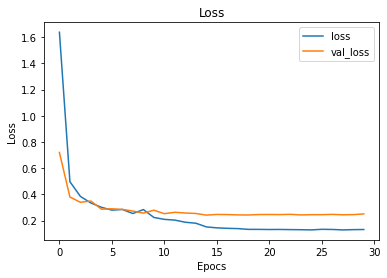

In [33]:
# graph training...
history_df = pd.DataFrame(history.history)
plt.figure()
history_df[['loss', 'val_loss']].plot(title="Loss")
plt.xlabel('Epocs')
plt.ylabel('Loss')

plt.show()

#history_df
